### Lennard-Jones势

$$V(r) = 4 \varepsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^6 \right]$$

其中：
- $V(r)$  是作为分离距离 $r$ 的函数的势能。
- $\varepsilon$  是势阱的深度。
- $\sigma$  是两个粒子之间的势能为零的有限距离。
- $r$  是两个粒子之间的距离。

In [1]:
"""Lennard-Jones 势及势场截断实现"""

# reference code:
# https://nb.bohrium.dp.tech/detail/9619862904


def lj_potential(r: float, epsilon: float, sigma: float) -> float:
    """
    Calculate the Lennard-Jones potential between two particles.

    Parameters:
    - r (float): Distance between the two particles.
    - epsilon (float): Depth of the potential well.
    - sigma (float): Finite distance at which the inter-particle potential is zero.

    Returns:
    - V (float): Lennard-Jones potential.
    """

    V = 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)
    return V

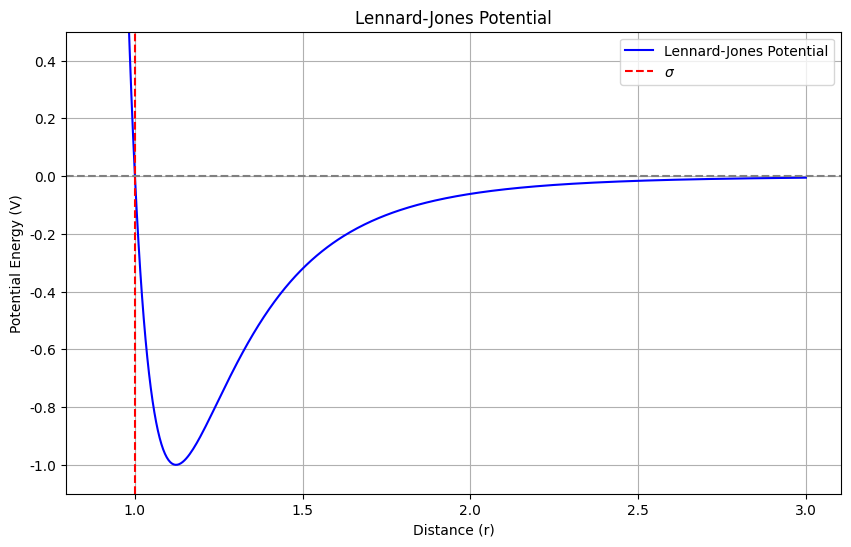

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters for the plot
epsilon = 1.0  # arbitrary unit
sigma = 1.0  # arbitrary unit
# We avoid starting from zero to prevent division by zero
r_values = np.linspace(0.9 * sigma, 3 * sigma, 400)
V_values = [lj_potential(r, epsilon, sigma) for r in r_values]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(r_values, V_values, label="Lennard-Jones Potential", color="blue")
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(sigma, color="red", linestyle="--", label=r"$\sigma$")
plt.title("Lennard-Jones Potential")
plt.xlabel("Distance (r)")
plt.ylabel("Potential Energy (V)")
plt.ylim([-1.1, 0.5])
plt.legend()
plt.grid(True)
plt.show()

### 受力

原子2作用在原子1上的力为：

$$
F = 24 * \frac{\epsilon}{r^2} * \left(2 \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^{6}\right) r_{\text{vec}}
$$

其中

$r_{\text{vec}}=r_1-r_2$，这也是程序中的位移。

In [3]:
import numpy as np


def lj_force_vector(r_vector: np.array, epsilon: float, sigma: float) -> np.array:
    """
    Calculate the Lennard-Jones force vector between two particles.

    Parameters:
    - r_vector (list or numpy array): 3D vector representing the distance from particle 2 to particle 1.
    - epsilon (float): Depth of the potential well.
    - sigma (float): Finite distance at which the inter-particle potential is zero.

    Returns:
    - F_vector (numpy array): 3D Lennard-Jones force vector.
    """

    r_magnitude = np.linalg.norm(r_vector)
    F_magnitude = (
        24
        * epsilon
        * ((2 * (sigma / r_magnitude) ** 12) - (sigma / r_magnitude) ** 6)
        / r_magnitude
    )

    F_vector = (r_vector / r_magnitude) * F_magnitude
    return F_vector

In [4]:
# Define test parameters
epsilon_test = 1.0
sigma_test = 1.0

# Test the function with a sample vector
# particle 1 is at (0.0, 0.0, 0.0) and particle 2 at (-1.0, 0.0, 0.0)
test_vector = np.array([1.0, 0.0, 0.0])
lj_force_vector(test_vector, epsilon_test, sigma_test)

array([24.,  0.,  0.])

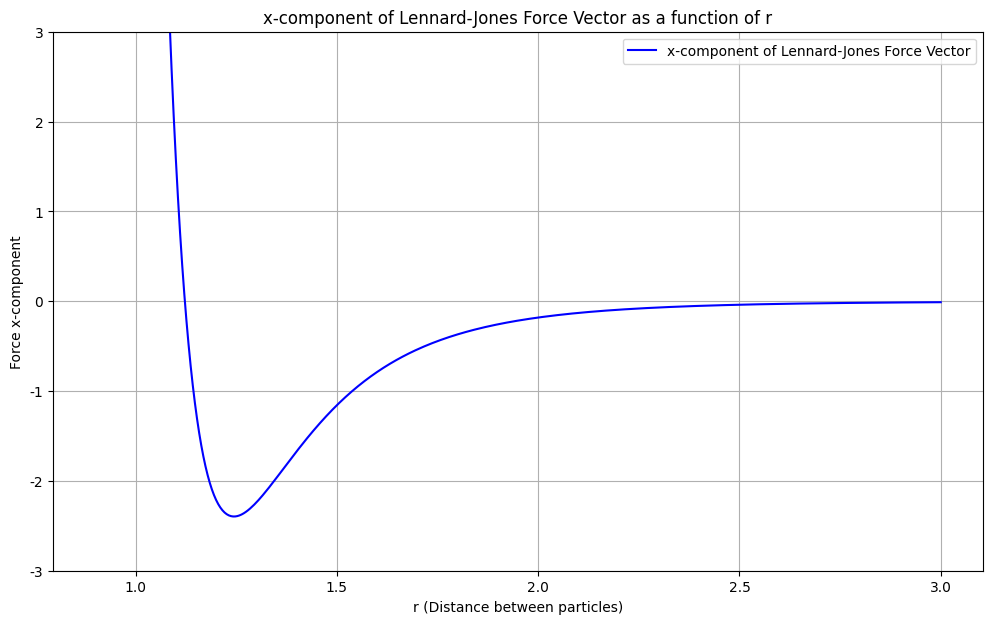

In [5]:
# Compute the first component of the force vector for r_vector values ranging from [0.9, 0, 0] to [3.0, 0, 0]
r_values_force = np.linspace(0.9, 3.0, 400)
force_x_values = [lj_force_vector([r, 0.0, 0.0], 1.0, 1.0)[0] for r in r_values_force]

# Plotting the x-component of the force vector with updated y-axis limits
plt.figure(figsize=(12, 7))
plt.plot(
    r_values_force,
    force_x_values,
    label="x-component of Lennard-Jones Force Vector",
    color="blue",
)
plt.xlabel("r (Distance between particles)")
plt.ylabel("Force x-component")
plt.ylim([-3, 3])  # Setting the y-axis limits
plt.legend()
plt.title("x-component of Lennard-Jones Force Vector as a function of r")
plt.grid(True)
plt.show()

### 势场的截断

Lennard-Jones (LJ) 势是用于描述原子或分子间非键合相互作用的简化模型。在分子动力学模拟中，为了提高效率，通常会在某一截断半径内考虑势能的影响，而忽略超出这一范围的势能效应。但简单地在给定的截断距离截断势能可能会引入不连续性，从而影响模拟的准确性。

为了解决这个问题，通常会使用平滑的截断方案，其中cosine截断是其中之一。cosine截断方法在接近截断半径时平滑地使势能下降到零，从而避免了势能的突然变化。

具体来说，cosine截断可以定义为：

$$ f(r) = \frac{1}{2} \left(1 - \cos\left(\pi \frac{r_c -r}{r_c-r_s}\right)\right) $$

其中，$ f(r) $ 是修正因子，当 $ r $ 在 $ r_s $ 和 $ r_c $ 之间时，它将Lennard-Jones势平滑地从其完整值过渡到零。这里，$ r_c $ 是截断半径，而 $ r_s $ 是一个用户定义的参数，描述了过渡区域的起始点。

In [6]:
def switching_function(
    r: float, switching_start: float, cutoff_distance: float
) -> float:
    """
    Compute the switching function value based on the distance between two particles.

    Parameters
    ----------
    r : float
        Distance between two particles.
    switching_start : float
        Distance where the switching function starts.
    cutoff_distance : float
        Cutoff distance for the potential.

    Returns
    -------
    float
        The value of the switching function at distance r.
    """

    # Check the distance against the switching start and cutoff distance
    if r < switching_start:
        return 1.0
    elif r > cutoff_distance:
        return 0.0

    # Compute the normalized distance within the switching interval
    # t=1 when r=switching_start;  t=0 when r=cutoff_distance
    t = (cutoff_distance - r) / (cutoff_distance - switching_start)

    # Compute the switching function based on the chosen method

    return 0.5 * (1 - np.cos(np.pi * t))

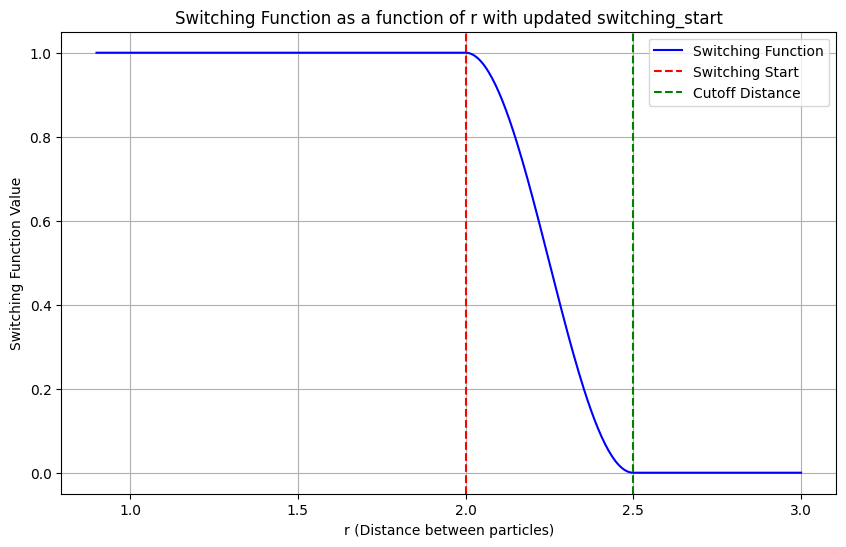

In [7]:
# Update switching_start value
switching_start = 2.0
cutoff_distance = 2.5

# Recompute switching function values
switching_values = [
    switching_function(r, switching_start, cutoff_distance) for r in r_values
]

plt.figure(figsize=(10, 6))
plt.plot(r_values, switching_values, label="Switching Function", color="blue")
plt.axvline(x=switching_start, color="red", linestyle="--", label="Switching Start")
plt.axvline(x=2.5, color="green", linestyle="--", label="Cutoff Distance")
plt.xlabel("r (Distance between particles)")
plt.ylabel("Switching Function Value")
plt.legend()
plt.title("Switching Function as a function of r with updated switching_start")
plt.grid(True)
plt.show()

### 截断后势能表达式

利用cos修正因子，带有cosine截断的Lennard-Jones势可以写为：

$$ V_{\text{cosine}}(r) = f(r) \times 4\epsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^{6} \right]$$

当 $ r $ 大于 $ r_c $ 时，$ V_{\text{cosine}}(r) $ 为零。

cosine截断不仅可以保证势能和力在截断半径处的连续性，还能在某些情况下提高模拟的准确性，尤其是当液体或气体系统的密度较低时。

In [8]:
def lj_potential_cutoff(
    r: float,
    epsilon: float,
    sigma: float,
    switching_start: float,
    cutoff_distance: float,
) -> float:
    """
    Calculate the Lennard-Jones potential between two particles with cutoff.

    Parameters:
    - r (float): Distance between the two particles.
    - epsilon (float): Depth of the potential well.
    - sigma (float): Finite distance at which the inter-particle potential is zero.
    - switching_start : float
        Distance where the switching function starts.
    - cutoff_distance : float
        Cutoff distance for the potential.

    Returns:
    - V (float): Lennard-Jones potential with cutoff.
    """

    V = lj_potential(r, epsilon, sigma) * switching_function(
        r, switching_start, cutoff_distance
    )
    return V

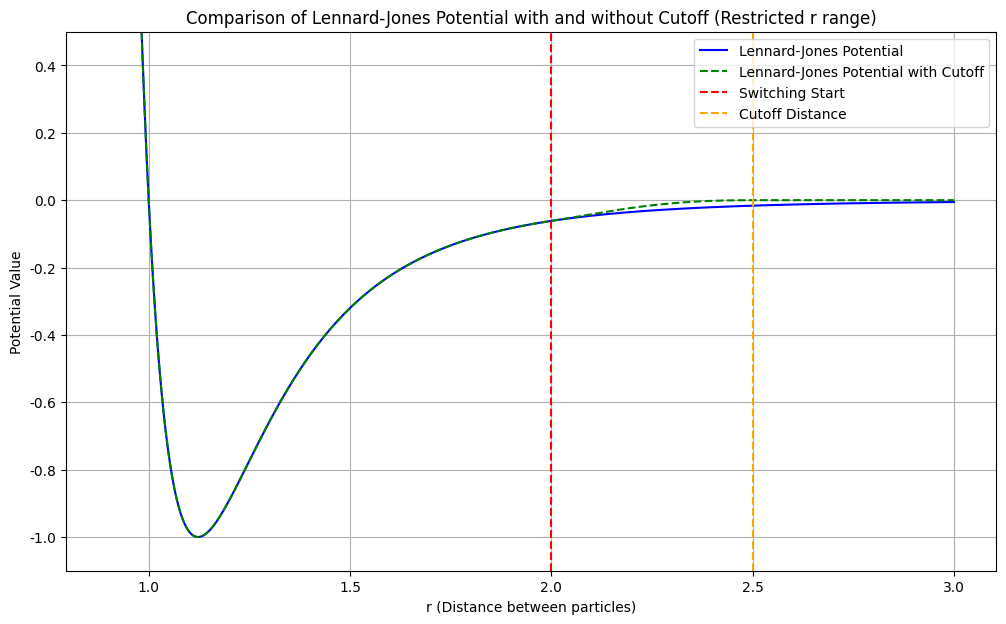

In [9]:
# Redefine r_values to be within the interval [0.9, 3]
r_values_restricted = np.linspace(0.9, 3, 400)

# Recompute Lennard-Jones potential values for the new r_values
lj_values_restricted = [
    lj_potential(r, epsilon_test, sigma_test) for r in r_values_restricted
]
lj_cutoff_values_restricted = [
    lj_potential_cutoff(r, epsilon_test, sigma_test, switching_start, 2.5)
    for r in r_values_restricted
]

plt.figure(figsize=(12, 7))
plt.plot(
    r_values_restricted,
    lj_values_restricted,
    label="Lennard-Jones Potential",
    color="blue",
)
plt.plot(
    r_values_restricted,
    lj_cutoff_values_restricted,
    label="Lennard-Jones Potential with Cutoff",
    color="green",
    linestyle="--",
)
plt.axvline(x=switching_start, color="red", linestyle="--", label="Switching Start")
plt.axvline(x=2.5, color="orange", linestyle="--", label="Cutoff Distance")
plt.xlabel("r (Distance between particles)")
plt.ylabel("Potential Value")
plt.ylim([-1.1, 0.5])
plt.legend()
plt.title(
    "Comparison of Lennard-Jones Potential with and without Cutoff (Restricted r range)"
)
plt.grid(True)
plt.show()

### 截断后受力表达式

Switching function（或切换函数）在分子动力学中常用于势能的截断处理，确保在截断距离附近势能和力平滑地趋近于零，从而避免不连续性和相关的数值问题。

给定一个切换函数 $ S(r) $，当我们考虑势能的计算时，不仅需要知道 $ S(r) $ 的值，还需要知道其对于原子间距离 $ r $ 的导数，因为力是势能关于距离的导数。具体地说，势能函数 $ V(r) $ 对应的力 $ F(r) $ 可以表示为：

$$ F(r) = -\frac{dV(r)}{dr} $$

如果我们有一个截断处理后的势能 $ V_{\text{mod}}(r) = V(r) \times S(r) $，其中 $ V(r) $ 是原始的未经截断的势能，那么对应的力可以表示为：

$$ F_{\text{mod}}(r) = -\frac{d(V(r) \times S(r))}{dr} $$

为了计算上述导数，我们需要同时考虑 $ V(r) $ 和 $ S(r) $ 的导数。特别是，我们需要知道切换函数 $ S(r) $ 对于 $ r $ 的导数，因为这影响了计算出的力的值。总的来说，了解切换函数的导数在分子动力学模拟中是至关重要的，因为它直接影响到计算得到的原子间的力，这些力决定了原子的运动轨迹和模拟的动力学性质。

Cosine切换函数是分子动力学中用于势能截断的一种常见方法。它的主要优点是在截断距离附近提供平滑的过渡，以避免在原子间势能和力中的不连续性。

设定一个截断距离 $ r_c $，在 $ r \leq r_{\text{start}} $ 时，势能保持不变，而在 $ r_{\text{start}} < r \leq r_c $ 之间，势能开始经过cosine切换函数平滑地趋向于0。

Cosine切换函数的一种常见形式为：
$$ S(r) = \frac{1}{2} \left(1 - \cos\left(\pi \frac{r_c - r}{r_c - r_{\text{start}}}\right)\right) $$

当 $ r \leq r_{\text{start}} $ 时，$ S(r) = 1 $；
当 $ r > r_c $ 时，$ S(r) = 0 $。

对于上述切换函数，其对 $ r $ 的导数是：
$$ \frac{dS(r)}{dr} = -\frac{\pi}{2(r_c - r_{\text{start}})} \sin\left(\pi \frac{r_c - r}{r_c - r_{\text{start}}}\right) $$

这个导数是计算在截断范围内原子间的力时必要的，因为力是势能相对于距离的导数。

使用cosine切换函数及其导数，可以确保在截断距离附近势能和力都是平滑的，这是在分子动力学模拟中避免不物理的行为和数值不稳定性的关键。

In [10]:
def switching_func_derivative(
    r: float, switching_start: float, cutoff_distance: float
) -> float:
    """
    Compute the derivative of the switching function based on the distance between two particles.

    Parameters
    ----------
    r : float
        Distance between two particles.
    switching_start : float
        Distance where the switching function starts.
    cutoff_distance : float
        Cutoff distance for the potential.

    Returns
    -------
    float
        The derivative of the switching function at distance r.
    """

    if r < switching_start or r > cutoff_distance:
        return 0.0
    else:
        return (
            -0.5
            * (np.pi / (cutoff_distance - switching_start))
            * np.sin(
                np.pi * (cutoff_distance - r) / (cutoff_distance - switching_start)
            )
        )

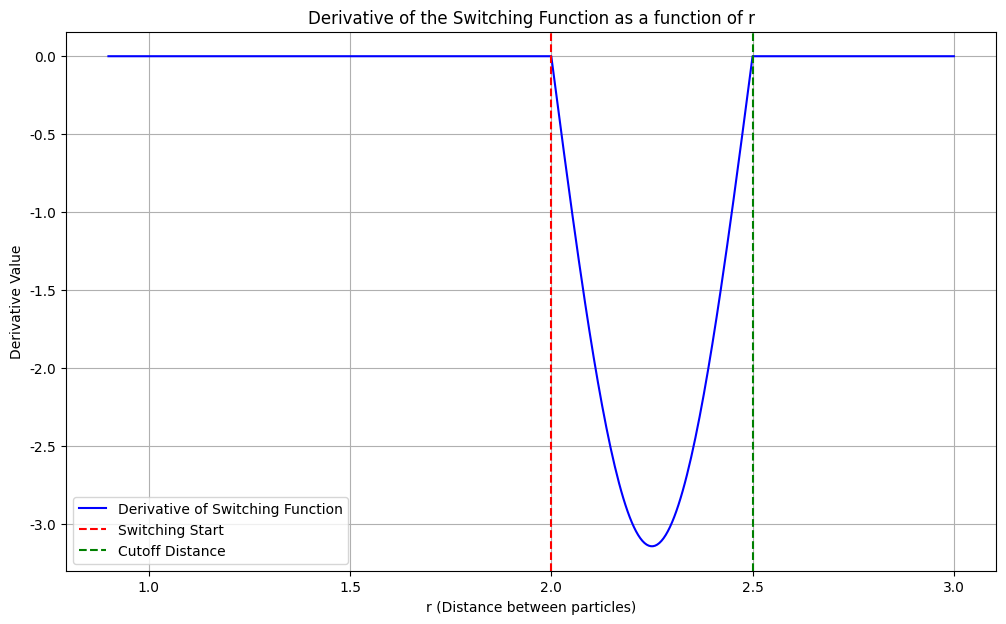

In [11]:
# Generate values for the derivative of the switching function
r_values_derivative = np.linspace(0.9, 3, 400)
switching_derivative_values = [
    switching_func_derivative(r, 2.0, 2.5) for r in r_values_derivative
]

plt.figure(figsize=(12, 7))
plt.plot(
    r_values_derivative,
    switching_derivative_values,
    label="Derivative of Switching Function",
    color="blue",
)
plt.axvline(x=2.0, color="red", linestyle="--", label="Switching Start")
plt.axvline(x=2.5, color="green", linestyle="--", label="Cutoff Distance")
plt.xlabel("r (Distance between particles)")
plt.ylabel("Derivative Value")
plt.legend()
plt.title("Derivative of the Switching Function as a function of r")
plt.grid(True)
plt.show()

In [12]:
def lj_force_vector_cutoff(
    r_vector: np.array,
    epsilon: float,
    sigma: float,
    switching_start: float,
    cutoff_distance: float,
) -> np.array:
    """
    Compute the Lennard-Jones force on a given particle due to all of its neighboring particles,
    considering the cutoff.

    Parameters
    ----------

    Returns
    -------
    net_force : np.array
        The total force exerted on the target particle.
    """
    net_force = np.zeros_like(r_vector, dtype=float)

    r_magnitude = np.linalg.norm(r_vector)

    if r_magnitude <= cutoff_distance:
        # Compute force without considering cutoff
        force_magnitude = (
            24
            * epsilon
            * ((2 * (sigma / r_magnitude) ** 12) - (sigma / r_magnitude) ** 6)
            / r_magnitude
        )

        switching_value = switching_function(
            r_magnitude, switching_start, cutoff_distance
        )
        switching_derivative = switching_func_derivative(
            r_magnitude, switching_start, cutoff_distance
        )
        force_magnitude *= switching_value
        # Add extra force due to derivative of switching function
        force_magnitude -= (
            switching_derivative
            * 4
            * epsilon
            * ((sigma / r_magnitude) ** 12 - (sigma / r_magnitude) ** 6)
        )

        # Add force vector to total force
        net_force = force_magnitude * (r_vector / r_magnitude)

    return net_force

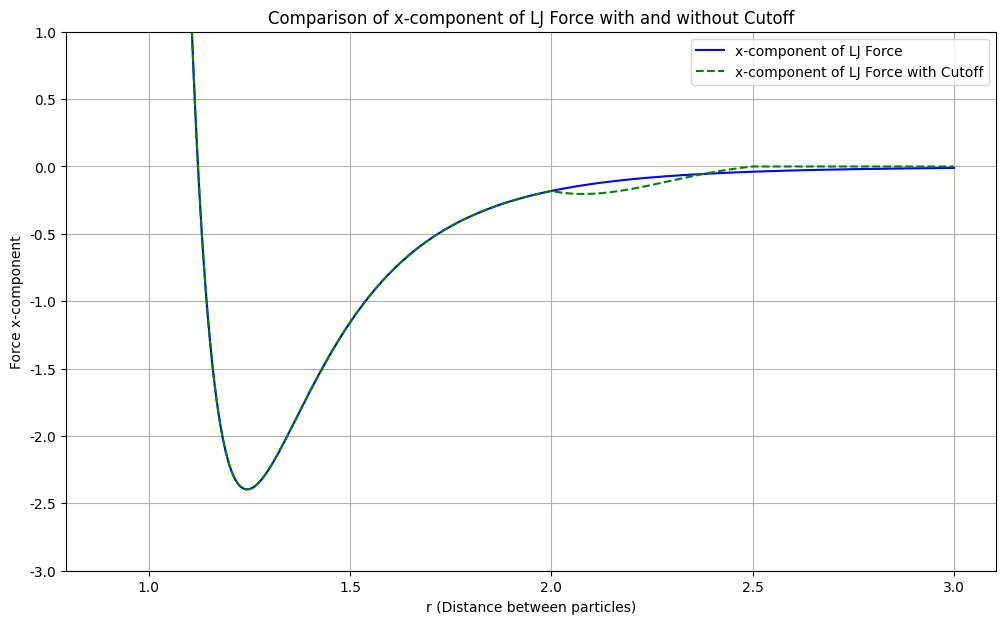

In [13]:
# Compute the first component of the net force vector for r_vector values ranging from [0.9, 0, 0] to [3.0, 0, 0]
r_values_force = np.linspace(0.9, 3.0, 400)
force_x_cutoff_values = [
    lj_force_vector_cutoff(np.array([r, 0, 0]), 1.0, 1.0, 2.0, 2.5)[0]
    for r in r_values_force
]

plt.figure(figsize=(12, 7))
plt.plot(r_values_force, force_x_values, label="x-component of LJ Force", color="blue")
plt.plot(
    r_values_force,
    force_x_cutoff_values,
    label="x-component of LJ Force with Cutoff",
    color="green",
    linestyle="--",
)
plt.xlabel("r (Distance between particles)")
plt.ylabel("Force x-component")
plt.ylim([-3, 1])  # Setting the y-axis limits
plt.legend()
plt.title("Comparison of x-component of LJ Force with and without Cutoff")
plt.grid(True)
plt.show()